# Uniformization

In this notebook, we are going to demonstrate how we do uniformization. Uniformization is when we turn any univariate distribution into a uniform distribution. This works by taking finding the CDF of a function

This is mainly used for inverse sampling but in theory, we can go from a uniform distribution to any other distribution but taking

In [11]:
import os, sys
from pyprojroot import here
# sys.path.insert(0, f"{cwd}/../")
sys.path.append(str(here()))

from rbig.data import ToyData
from rbig.transform.uniformization import HistogramUniformization, KDEUniformization

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [12]:
def gen_uni_data(n_samples: int, a: float, seed: int=123) -> np.ndarray:
    return stats.gamma(a=a).rvs(size=(n_samples, 1), random_state=seed)

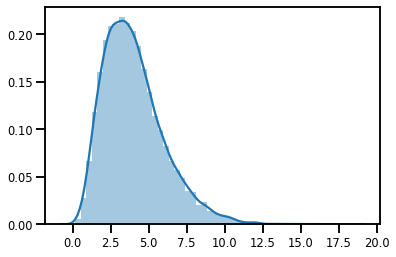

In [13]:
# parameters
seed = 123
n_samples = 10_000
a = 4

# get some samples
X = gen_uni_data(n_samples, a, seed)

# plot distribution
sns.distplot(X)

So for this example, we are using a Beta distribution with an $\alpha$ value of 4 to generate a slightly skewed distribution.

## Method I - Histograms

For this first model, we will be using a simple histogram method. This works by binning the data 

### Fit Model to Distribution

In [58]:
# initialize HistogramClass
bins = 1_000 #int(np.sqrt(n_samples))
support_extension = 10
alpha = 1e-7
marg_hist_clf = HistogramUniformization(
    bins=bins,
    support_extension=support_extension,
    alpha=alpha,
#     n_quantiles=100,
)

# fit to data
marg_hist_clf.fit(X)

HistogramUniformization(alpha=1e-07, bins=1000, kwargs={}, n_quantiles=None,
                        prob_tol=1e-07, random_state=123, subsample=10000,
                        support_extension=10)

In [59]:
X.min(), X.max()

(0.16885335848364358, 18.275140139054425)

In [60]:
marg_hist_clf.estimator_.estimator_.entropy(), marg_hist_clf.estimator_.entropy()

(array(1.99190104), array(2.01720104))

### Transform Data

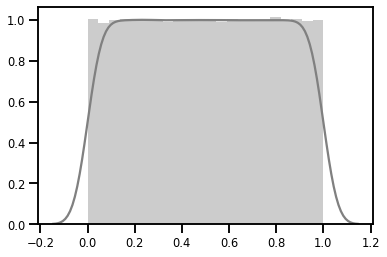

In [61]:
# transform data
Xu = marg_hist_clf.transform(X)

sns.distplot(Xu, color='gray')

### Inverse Transform Data

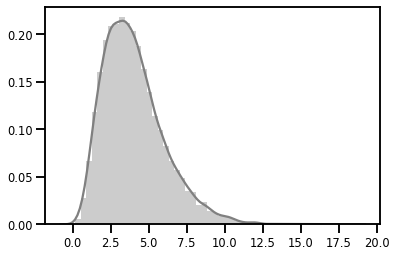

In [62]:
# transform data
X_approx = marg_hist_clf.inverse_transform(Xu)

sns.distplot(X_approx, color='gray')

### Sampling

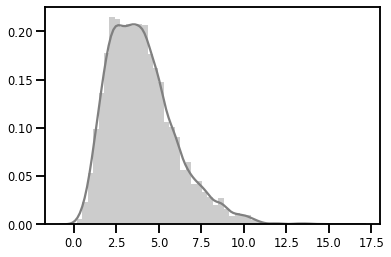

In [63]:
# transform data
X_samples = marg_hist_clf.sample(10_000, seed)

sns.distplot(X_samples, color='gray')

### Jacobian (Log Absolute Determinant)

-5.381144136387655 -1.303628051526641


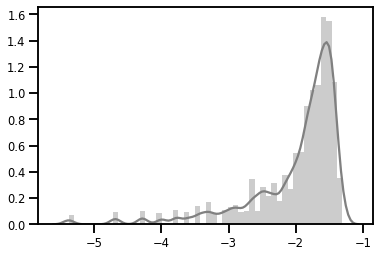

In [64]:
# estimated log probability of dataset
x_slogdet = marg_hist_clf.log_abs_det_jacobian(X)

print(x_slogdet.min(), x_slogdet.max())
sns.distplot(x_slogdet, color='gray')

In [65]:
10 * np.spacing(1)

2.220446049250313e-15

In [210]:
print(f"Min: {X.min()}, Max: {X.max()}")

X_small_samples = data_dist.rvs(size=(10, 1), random_state=seed)

# check bounds (lower bounds)
x_slogdet = marg_hist_clf.log_abs_det_jacobian(X_small_samples)
print(x_slogdet.min(), x_slogdet.max())

# check bounds (lower bounds)
x_slogdet = marg_hist_clf.log_abs_det_jacobian(X_small_samples - 100)
print(x_slogdet.min(), x_slogdet.max(), marg_hist_clf.marginal_transforms_[0].b)

# check bounds (lower bounds)
x_slogdet = marg_hist_clf.log_abs_det_jacobian(X_small_samples + 100)
print(x_slogdet.min(), x_slogdet.max())

Min: 0.16885335848364358, Max: 18.275140139054425
-3.1374212707246407 -1.3158088383469049
-42.376678031427744 -42.376678031427744 21.896397495168582
-42.376678031427744 -42.376678031427744


### Log Probability

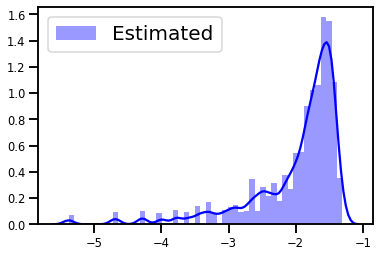

In [66]:
# calculate real log probability of distribution
x_prob = marg_hist_clf.score_samples(X)
# data_prob = data_dist.logpdf(X)

# sns.distplot(data_prob, color='black', label='Dataset')
sns.distplot(x_prob, color='blue', label='Estimated')

plt.legend(fontsize=20)

### Negative Log-Likelihood

In [67]:
x_score = marg_hist_clf.score_samples(X).mean()
# data_score = data_dist.logpdf(X).mean()
print(x_score)

-1.9918804465499542


## Method II - KDE Method (Exact)

In [127]:
# initialize HistogramClass
bw_method = 'scott'
n_quantiles = 100
support_extension = 10
method = 'exact'
interp = True
marg_kde_clf = KDEUniformization(
    bw_method=bw_method,
    n_quantiles=n_quantiles,
    support_extension=support_extension,
    method=method,
    interp=interp
)

# fit to data
marg_kde_clf.fit(X)

-1.6417753195734346 20.085768817111504


KDEUniformization(algorithm='kd_tree', bw_method='scott', interp=True,
                  kernel='gaussian', kwargs={}, method='exact',
                  metric='euclidean', n_quantiles=100, norm=2,
                  support_extension=10)

### Transform Data

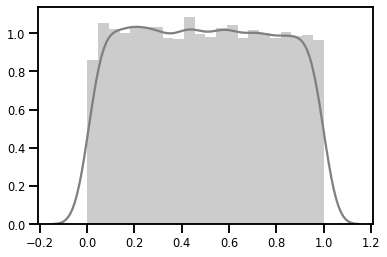

In [128]:
# transform data
Xu = marg_kde_clf.transform(X)

sns.distplot(Xu, color='gray')

### Inverse Transformation

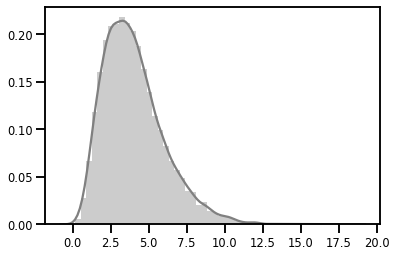

In [129]:
# transform data
X_approx = marg_kde_clf.inverse_transform(Xu)

sns.distplot(X_approx, color='gray')

### Sampling

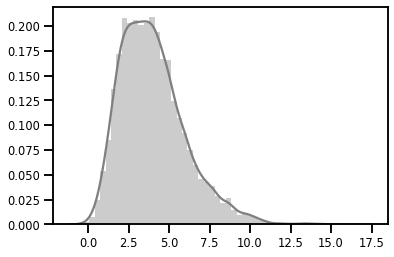

In [130]:
# transform data
X_samples = marg_kde_clf.sample(10_000, seed)

sns.distplot(X_samples, color='gray')

### Jacobian (Log Absolute Determinant)

In [131]:
# estimated log probability of dataset
x_slogdet = marg_kde_clf.log_abs_det_jacobian(X)

print(x_slogdet.min(), x_slogdet.max())

-9.022726688927058 -1.5404074121908016


### Log Probability

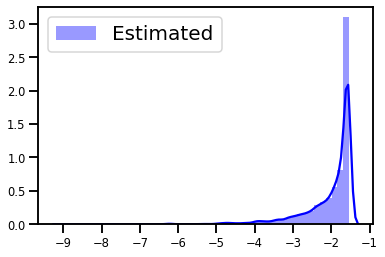

In [132]:
# calculate real log probability of distribution
x_prob = marg_kde_clf.score_samples(X)
# data_prob = data_dist.logpdf(X)

# sns.distplot(data_prob, color='black', label='Dataset')
sns.distplot(x_prob, color='blue', label='Estimated')

plt.legend(fontsize=20)

### Negative Log-Likelihood

In [133]:
x_score = marg_kde_clf.score(X)
# data_score = data_dist.logpdf(X).mean()
print(x_score)

-2.0244657819670646


In [226]:
x_score = marg_kde_clf.score(X)
# data_score = data_dist.logpdf(X).mean()
print(x_score)

-2.0242577919872082


## Method III - KDE Estimation (FFT)

There is a faster version of the KDE estimation called the FFT

In [233]:
# initialize HistogramClass
bw_method = 'scott'
n_quantiles = 100
support_extension = 10
method = 'fft'
interp = True
marg_kde_clf = KDEUniformization(
    bw_method=bw_method,
    n_quantiles=n_quantiles,
    support_extension=support_extension,
    method=method,
    interp=interp
)

# fit to data
marg_kde_clf.fit(X)

KDEUniformization(algorithm='kd_tree', bw_method='scott', interp=True,
                  kernel='gaussian', kwargs={}, method='fft',
                  metric='euclidean', n_quantiles=100, norm=2,
                  support_extension=10)

#### Transform

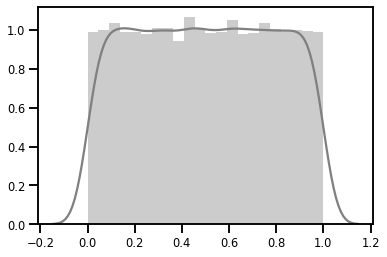

In [234]:
# transform data
Xu = marg_kde_clf.transform(X)

sns.distplot(Xu, color='gray')

#### Inverse Transformation

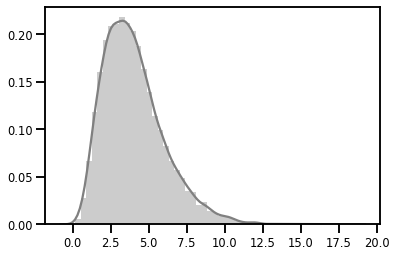

In [235]:
# transform data
X_approx = marg_kde_clf.inverse_transform(Xu)

sns.distplot(X_approx, color='gray')

#### Sampling

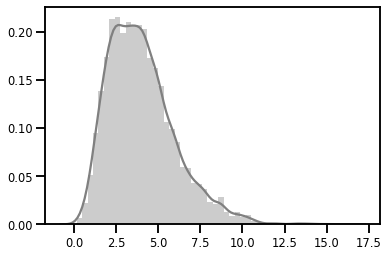

In [236]:
# transform data
X_samples = marg_kde_clf.sample(10_000, seed)

sns.distplot(X_samples, color='gray')

#### Log Determinant Jacobian / Log Probability

-9.02700588899877 -1.5404670711035093


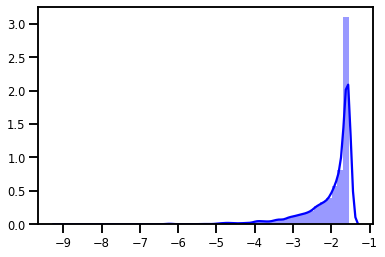

In [237]:
# estimated log probability of dataset
x_slogdet = marg_kde_clf.log_abs_det_jacobian(X)

# calculate real log probability of distribution
x_prob = marg_kde_clf.score_samples(X)
np.testing.assert_array_equal(x_slogdet, x_prob)

print(x_slogdet.min(), x_slogdet.max())

sns.distplot(x_slogdet, color='blue', label='Estimated')

In [238]:
x_score = marg_kde_clf.score(X)
# data_score = data_dist.logpdf(X).mean()
print(x_score)

-2.0245011478640538


## Method IV - KDE + Epa Kernel

In [239]:
# initialize HistogramClass
bw_method = 'scott'
n_quantiles = 1000
support_extension = 10
method = 'epa'
kernel = 'epa'
marg_kde_clf = KDEUniformization(
    bw_method=bw_method,
    n_quantiles=n_quantiles,
    support_extension=support_extension,
    method=method,
    kernel=kernel,
)

# fit to data
marg_kde_clf.fit(X)

KDEUniformization(algorithm='kd_tree', bw_method='scott', interp=True,
                  kernel='epa', kwargs={}, method='epa', metric='euclidean',
                  n_quantiles=1000, norm=2, support_extension=10)

### Transform

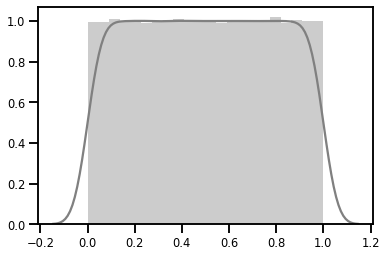

In [240]:
# transform data
Xu = marg_kde_clf.transform(X)

sns.distplot(Xu, color='gray')

### Inverse Transform

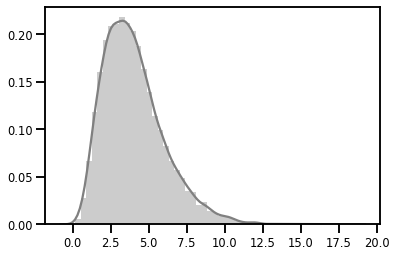

In [241]:
# transform data
X_approx = marg_kde_clf.inverse_transform(Xu)

sns.distplot(X_approx, color='gray')

### Sampling

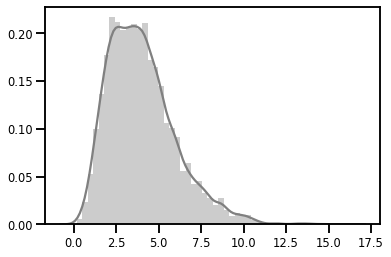

In [242]:
# transform data
X_samples = marg_kde_clf.sample(10_000, seed)

sns.distplot(X_samples, color='gray')

### Jacobian

-9.100207246140727 -1.537109125471677


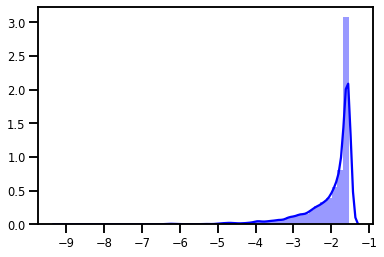

In [243]:
# estimated log probability of dataset
x_slogdet = marg_kde_clf.log_abs_det_jacobian(X)

# calculate real log probability of distribution
x_prob = marg_kde_clf.score_samples(X)
np.testing.assert_array_equal(x_slogdet, x_prob)

print(x_slogdet.min(), x_slogdet.max())

sns.distplot(x_slogdet, color='blue', label='Estimated')